In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
# For handling Excel files
import openpyxl
# For progress bars
from tqdm.notebook import tqdm
# Setting plot style
sns.set(style="whitegrid")
%matplotlib inline
import glob
import shutil
import random
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Define the base directory
base_dir = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

# List all files and directories in the base directory
print("Contents of the base directory:")
print(os.listdir(base_dir))

Contents of the base directory:
['Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'README.md.txt', 'COVID.metadata.xlsx', 'Normal', 'Lung_Opacity', 'Viral Pneumonia.metadata.xlsx', 'Viral Pneumonia', 'COVID']


In [3]:
# Find all metadata files in the base directory
metadata_files = glob.glob(os.path.join(base_dir, '*.metadata.xlsx'))

print("\nFound Metadata Files:")
for file in metadata_files:
    print(os.path.basename(file))


Found Metadata Files:
Lung_Opacity.metadata.xlsx
Normal.metadata.xlsx
COVID.metadata.xlsx
Viral Pneumonia.metadata.xlsx


In [4]:
root_dir ='/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset'

classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Initialize a dictionary to hold metadata DataFrames
metadata = {}

for cls in classes:
    # Special case for 'Viral Pneumonia'
    if cls == 'Viral Pneumonia':
        metadata_path = os.path.join(root_dir, 'Viral Pneumonia.metadata.xlsx')
    else:
        metadata_path = os.path.join(root_dir, f'{cls}.metadata.xlsx')
        
    if os.path.exists(metadata_path):
        metadata_df = pd.read_excel(metadata_path)
        metadata[cls] = metadata_df
        print(f"Loaded metadata for class: {cls} with {len(metadata_df)} entries.")
    else:
        print(f"Metadata file for class {cls} not found at {metadata_path}.")


Loaded metadata for class: COVID with 3616 entries.
Loaded metadata for class: Lung_Opacity with 6012 entries.
Loaded metadata for class: Normal with 10192 entries.
Loaded metadata for class: Viral Pneumonia with 1345 entries.


In [5]:
# Inspect columns for each metadata DataFrame
for cls in classes:
    if cls in metadata:
        print(f"\nColumns in {cls} Metadata:")
        print(metadata[cls].columns)



Columns in COVID Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Lung_Opacity Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Normal Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')

Columns in Viral Pneumonia Metadata:
Index(['FILE NAME', 'FORMAT', 'SIZE', 'URL'], dtype='object')


In [6]:
class COVID19RadiographyDataset(Dataset):
    def __init__(self, image_label_pairs, transform=None):
        """
        Args:
            image_label_pairs (list of tuples): List where each tuple contains (image_path, label).
            transform (callable, optional): Optional transform to be applied on an image.
        """
        self.image_label_pairs = image_label_pairs
        self.transform = transform

    def __len__(self):
        return len(self.image_label_pairs)

    def __getitem__(self, idx):
        image_path, label = self.image_label_pairs[idx]
#         print(f"Loading image from: {image_path}")
        
        # Load image
        image = Image.open(image_path).convert('RGB')  # Ensure 3 channels
        
        # Print the size of the image to check channels
#         print(f"Image size: {image.size}, Image mode: {image.mode}")
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [7]:
# Define image transformations for training
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Define image transformations for validation and testing
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


In [8]:
# Define class names
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Define label indices
label_mapping = {cls: idx for idx, cls in enumerate(classes)}
# Initialize a list to hold all mapped data
all_mapped_data = []

# Iterate through each class and map images to their labels
for cls in classes:
    images_dir = os.path.join(root_dir, cls, 'images')
    
    # List all image filenames
    image_filenames = os.listdir(images_dir)
    
    for img_filename in image_filenames:
        img_path = os.path.join(images_dir, img_filename)
        
        # Append the image path and label to the mapped data list
        all_mapped_data.append((img_path, label_mapping[cls]))

# Optionally, print the mapped data
for img_path, label in all_mapped_data:
    print(f"Image Path: {img_path}, Label: {label}")
# Convert to DataFrame for easier inspection
mapped_df = pd.DataFrame(all_mapped_data, columns=['image_path', 'label'])

Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1994.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1825.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-517.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-532.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-2272.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-765.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-699.png, Label: 0
Image Path: /kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/images/COVID-1857.png, Label: 0
Image Path: /kaggle/input/co

In [9]:
# Display the first few entries
print("Mapped DataFrame:")
display(mapped_df.head())

# Check total number of mapped samples
print(f"Total images mapped: {len(mapped_df)}")

Mapped DataFrame:


image_path  label
0  /kaggle/input/covid19-radiography-database/COV...      0
1  /kaggle/input/covid19-radiography-database/COV...      0
2  /kaggle/input/covid19-radiography-database/COV...      0
3  /kaggle/input/covid19-radiography-database/COV...      0
4  /kaggle/input/covid19-radiography-database/COV...      0

Total images mapped: 21165


In [10]:
# Define split ratios
train_ratio = 0.7
val_ratio = 0.10
test_ratio = 0.20

# Calculate split sizes
total_size = len(mapped_df)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

print(f"Total samples: {total_size}")
print(f"Training samples: {train_size}")
print(f"Validation samples: {val_size}")
print(f"Testing samples: {test_size}")


Total samples: 21165
Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [11]:
# Shuffle the data
from sklearn.model_selection import train_test_split

# First split: Train and Temp (Val + Test)
train_data, temp_data = train_test_split(
    all_mapped_data,
    test_size=(1 - train_ratio),
    random_state=42,
    stratify=[x[1] for x in all_mapped_data]  # Stratify based on labels
)

# Second split: Validation and Test
val_size_adjusted = val_ratio / (val_ratio + test_ratio)  # Adjust validation size
val_data, test_data = train_test_split(
    temp_data,
    test_size=(1 - val_size_adjusted),
    random_state=42,
    stratify=[x[1] for x in temp_data]
)

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Testing samples: {len(test_data)}")


Training samples: 14815
Validation samples: 2116
Testing samples: 4234


In [12]:
from sklearn.utils.class_weight import compute_class_weight
# Extract labels from training data
train_labels = [sample[1] for sample in train_data]

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights = torch.tensor(class_weights, dtype=torch.float)
print(f"Class Weights: {class_weights}")


Class Weights: tensor([1.4634, 0.8802, 0.5192, 3.9318])


In [13]:
# Create Dataset instances
train_dataset = COVID19RadiographyDataset(train_data, transform=train_transform)
val_dataset = COVID19RadiographyDataset(val_data, transform=val_test_transform)
test_dataset = COVID19RadiographyDataset(test_data, transform=val_test_transform)

# Define batch size and number of workers
batch_size = 16
num_workers = 4

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

print(f"Number of batches - Train: {len(train_loader)}, Val: {len(val_loader)}, Test: {len(test_loader)}")

Number of batches - Train: 926, Val: 133, Test: 265


Training images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


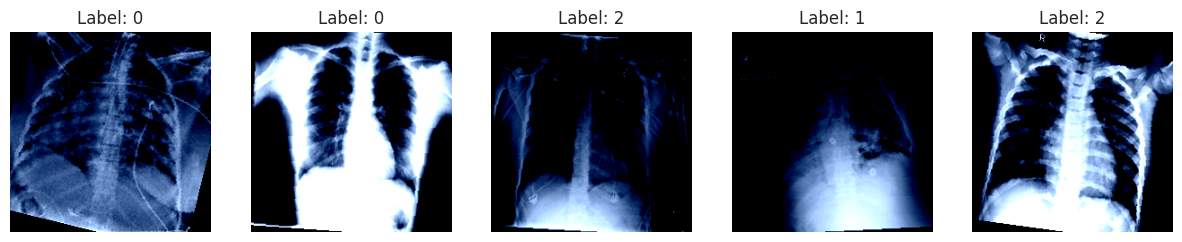

Validation images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


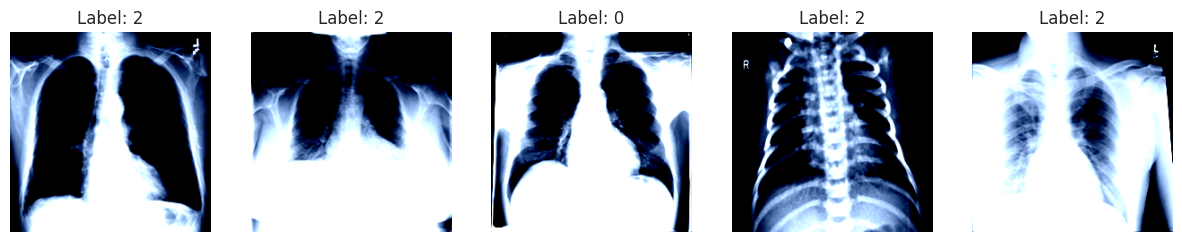

Testing images:
Image 1 shape: torch.Size([3, 224, 224])
Image 2 shape: torch.Size([3, 224, 224])
Image 3 shape: torch.Size([3, 224, 224])
Image 4 shape: torch.Size([3, 224, 224])
Image 5 shape: torch.Size([3, 224, 224])


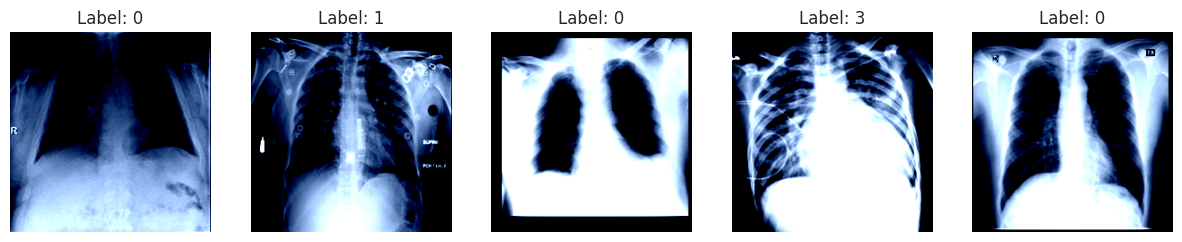

In [14]:
import matplotlib.pyplot as plt

def display_images_from_loader(loader, num_images=5):
    data_iter = iter(loader)
    images, labels = next(data_iter)

    # Ensure num_images does not exceed batch size
    num_images = min(num_images, images.size(0))  # Adjust if batch size is smaller

    # Create a figure with subplots
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i in range(num_images):
        ax = axes[i]
        image = images[i].permute(1, 2, 0).numpy()  # Convert from CxHxW to HxWxC
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')
        print(f"Image {i+1} shape: {images[i].shape}")  # Print image shape to verify resize

    plt.show()

# Check train_loader
print("Training images:")
display_images_from_loader(train_loader)

# Check val_loader
print("Validation images:")
display_images_from_loader(val_loader)

# Check test_loader
print("Testing images:")
display_images_from_loader(test_loader)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchvision.models import mobilenet_v2

In [16]:

import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

# Define the Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, in_channels):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, 1, kernel_size=7, stride=1, padding=3)
    
    def forward(self, x):
        # Apply convolution followed by sigmoid to get attention map
        attention = torch.sigmoid(self.conv1(x))
        return x * attention

# Define the Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels):
        super(ChannelAttention, self).__init__()
        self.fc1 = nn.Linear(in_channels, in_channels // 8)
        self.fc2 = nn.Linear(in_channels // 8, in_channels)
    
    def forward(self, x):
        # Squeeze the spatial dimensions (global average pooling)
        b, c, _, _ = x.size()
        squeeze = F.adaptive_avg_pool2d(x, 1)
        squeeze = squeeze.view(b, c)
        
        # Apply two fully connected layers with ReLU and sigmoid activations
        attention = F.relu(self.fc1(squeeze))
        attention = torch.sigmoid(self.fc2(attention)).view(b, c, 1, 1)
        
        return x * attention

# Define the ResNet50 with Dual Attention Network (DANet) architecture
class ResNet50_DAnet(nn.Module):
    def __init__(self, num_classes):
        super(ResNet50_DAnet, self).__init__()
        
        # Load ResNet50 without ImageNet weights (pretrained=False)
        self.resnet = models.resnet50(pretrained=False)
        
        # Extract ResNet50 feature extractor layers
        self.features = nn.Sequential(
            self.resnet.conv1,
            self.resnet.bn1,
            self.resnet.relu,
            self.resnet.maxpool,
            self.resnet.layer1,
            self.resnet.layer2,
            self.resnet.layer3,
            self.resnet.layer4
        )
        
        # Initialize attention modules
        final_out_channels = 2048  # Number of channels in ResNet50's final layer
        self.spatial_attention = SpatialAttention(final_out_channels)
        self.channel_attention = ChannelAttention(final_out_channels)
        
        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(final_out_channels, num_classes)

    def forward(self, x):
        # Extract features from ResNet50
        features = self.features(x)
        
        # Apply Spatial Attention
        features = self.spatial_attention(features)
        
        # Apply Channel Attention
        features = self.channel_attention(features)
        
        # Classification
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Initialize the model for multi-class classification
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # Adjust based on your dataset
model = ResNet50_DAnet(num_classes=num_classes).to(device)

# Check model architecture
print(model)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNet50_DAnet(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [17]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# num_classes = 4  # Replace with your number of classes
# model = MobileNetV2_NonLocal(num_classes).to(device)

# # Check model architecture
# print(model)

In [18]:
# Define loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device='cuda'):
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    best_model_wts = None
    
    print(f"Using device: {device}")
    
    # Move model to the correct device
    model = model.to(device)

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch + 1}/{num_epochs}')
        print('-' * 30)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data
            for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
                # Move data to the correct device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            # Scheduler step
            if phase == 'train':
                scheduler.step()
            
            # Calculate epoch loss and accuracy
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())
            
            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')
            
            # Check if this is the best model so far in validation phase
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict().copy()
        
        print(f"End of Epoch {epoch + 1}: Train Loss - {history['train_loss'][-1]:.4f}, "
              f"Val Loss - {history['val_loss'][-1]:.4f}")
    
    print(f'\nTraining complete. Best Validation Accuracy: {best_acc:.4f}')
    
    # Load best model weights
    if best_model_wts:
        model.load_state_dict(best_model_wts)
    
    return model, history

# Define number of epochs
num_epochs = 25

# Ensure you have set the device correctly (CUDA if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Assuming model, criterion, optimizer, scheduler, train_loader, and val_loader are defined properly

trained_model, history = train_model(
    model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs, device=device
)


Using device: cuda
Using device: cuda

Epoch 1/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:47<00:00,  5.54it/s]


Train Loss: 0.9391, Accuracy: 0.5562


Val Phase: 100%|██████████| 133/133 [00:08<00:00, 15.12it/s]


Val Loss: 0.7667, Accuracy: 0.6767
End of Epoch 1: Train Loss - 0.9391, Val Loss - 0.7667

Epoch 2/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:55<00:00,  5.28it/s]


Train Loss: 0.7297, Accuracy: 0.6636


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.26it/s]


Val Loss: 0.6381, Accuracy: 0.6782
End of Epoch 2: Train Loss - 0.7297, Val Loss - 0.6381

Epoch 3/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.6172, Accuracy: 0.7223


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.33it/s]


Val Loss: 0.5533, Accuracy: 0.7599
End of Epoch 3: Train Loss - 0.6172, Val Loss - 0.5533

Epoch 4/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:55<00:00,  5.29it/s]


Train Loss: 0.5370, Accuracy: 0.7616


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.39it/s]


Val Loss: 0.4410, Accuracy: 0.8062
End of Epoch 4: Train Loss - 0.5370, Val Loss - 0.4410

Epoch 5/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.30it/s]


Train Loss: 0.4933, Accuracy: 0.7809


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.28it/s]


Val Loss: 0.3703, Accuracy: 0.8407
End of Epoch 5: Train Loss - 0.4933, Val Loss - 0.3703

Epoch 6/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.32it/s]


Train Loss: 0.4541, Accuracy: 0.7985


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.29it/s]


Val Loss: 0.3619, Accuracy: 0.8256
End of Epoch 6: Train Loss - 0.4541, Val Loss - 0.3619

Epoch 7/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:55<00:00,  5.29it/s]


Train Loss: 0.4225, Accuracy: 0.8148


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.30it/s]


Val Loss: 0.4092, Accuracy: 0.8478
End of Epoch 7: Train Loss - 0.4225, Val Loss - 0.4092

Epoch 8/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:53<00:00,  5.33it/s]


Train Loss: 0.3867, Accuracy: 0.8315


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.39it/s]


Val Loss: 0.3692, Accuracy: 0.8162
End of Epoch 8: Train Loss - 0.3867, Val Loss - 0.3692

Epoch 9/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.30it/s]


Train Loss: 0.3645, Accuracy: 0.8385


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.30it/s]


Val Loss: 0.3194, Accuracy: 0.8681
End of Epoch 9: Train Loss - 0.3645, Val Loss - 0.3194

Epoch 10/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.30it/s]


Train Loss: 0.3461, Accuracy: 0.8498


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.40it/s]


Val Loss: 0.2800, Accuracy: 0.8762
End of Epoch 10: Train Loss - 0.3461, Val Loss - 0.2800

Epoch 11/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.2491, Accuracy: 0.8890


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.39it/s]


Val Loss: 0.2196, Accuracy: 0.9050
End of Epoch 11: Train Loss - 0.2491, Val Loss - 0.2196

Epoch 12/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:53<00:00,  5.33it/s]


Train Loss: 0.2303, Accuracy: 0.8981


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.38it/s]


Val Loss: 0.2121, Accuracy: 0.9078
End of Epoch 12: Train Loss - 0.2303, Val Loss - 0.2121

Epoch 13/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.2152, Accuracy: 0.9064


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.27it/s]


Val Loss: 0.2083, Accuracy: 0.9088
End of Epoch 13: Train Loss - 0.2152, Val Loss - 0.2083

Epoch 14/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:55<00:00,  5.29it/s]


Train Loss: 0.2104, Accuracy: 0.9087


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.30it/s]


Val Loss: 0.1995, Accuracy: 0.9220
End of Epoch 14: Train Loss - 0.2104, Val Loss - 0.1995

Epoch 15/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.32it/s]


Train Loss: 0.2023, Accuracy: 0.9102


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.25it/s]


Val Loss: 0.2000, Accuracy: 0.9130
End of Epoch 15: Train Loss - 0.2023, Val Loss - 0.2000

Epoch 16/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.32it/s]


Train Loss: 0.1985, Accuracy: 0.9108


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.30it/s]


Val Loss: 0.1885, Accuracy: 0.9182
End of Epoch 16: Train Loss - 0.1985, Val Loss - 0.1885

Epoch 17/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.30it/s]


Train Loss: 0.1906, Accuracy: 0.9152


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.45it/s]


Val Loss: 0.1958, Accuracy: 0.9102
End of Epoch 17: Train Loss - 0.1906, Val Loss - 0.1958

Epoch 18/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.32it/s]


Train Loss: 0.1789, Accuracy: 0.9190


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.29it/s]


Val Loss: 0.1909, Accuracy: 0.9154
End of Epoch 18: Train Loss - 0.1789, Val Loss - 0.1909

Epoch 19/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:53<00:00,  5.32it/s]


Train Loss: 0.1719, Accuracy: 0.9210


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.26it/s]


Val Loss: 0.1916, Accuracy: 0.9097
End of Epoch 19: Train Loss - 0.1719, Val Loss - 0.1916

Epoch 20/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:53<00:00,  5.33it/s]


Train Loss: 0.1721, Accuracy: 0.9229


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.37it/s]


Val Loss: 0.1932, Accuracy: 0.9230
End of Epoch 20: Train Loss - 0.1721, Val Loss - 0.1932

Epoch 21/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:55<00:00,  5.29it/s]


Train Loss: 0.1673, Accuracy: 0.9271


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.23it/s]


Val Loss: 0.1915, Accuracy: 0.9244
End of Epoch 21: Train Loss - 0.1673, Val Loss - 0.1915

Epoch 22/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.1601, Accuracy: 0.9268


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.29it/s]


Val Loss: 0.1839, Accuracy: 0.9234
End of Epoch 22: Train Loss - 0.1601, Val Loss - 0.1839

Epoch 23/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.1597, Accuracy: 0.9287


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.32it/s]


Val Loss: 0.1835, Accuracy: 0.9249
End of Epoch 23: Train Loss - 0.1597, Val Loss - 0.1835

Epoch 24/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:53<00:00,  5.32it/s]


Train Loss: 0.1543, Accuracy: 0.9278


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.29it/s]


Val Loss: 0.1841, Accuracy: 0.9234
End of Epoch 24: Train Loss - 0.1543, Val Loss - 0.1841

Epoch 25/25
------------------------------


Train Phase: 100%|██████████| 926/926 [02:54<00:00,  5.31it/s]


Train Loss: 0.1583, Accuracy: 0.9278


Val Phase: 100%|██████████| 133/133 [00:07<00:00, 17.36it/s]

Val Loss: 0.1833, Accuracy: 0.9239
End of Epoch 25: Train Loss - 0.1583, Val Loss - 0.1833

Training complete. Best Validation Accuracy: 0.9249


In [20]:
from sklearn.metrics import classification_report, confusion_matrix
def evaluate_model(model, dataloader, classes):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=classes))
    
    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

Testing: 100%|██████████| 265/265 [00:18<00:00, 14.26it/s]


Classification Report:
                 precision    recall  f1-score   support

          COVID       0.93      0.93      0.93       723
   Lung_Opacity       0.89      0.90      0.89      1203
         Normal       0.94      0.93      0.94      2039
Viral Pneumonia       0.95      0.99      0.97       269

       accuracy                           0.92      4234
      macro avg       0.93      0.94      0.93      4234
   weighted avg       0.92      0.92      0.92      4234



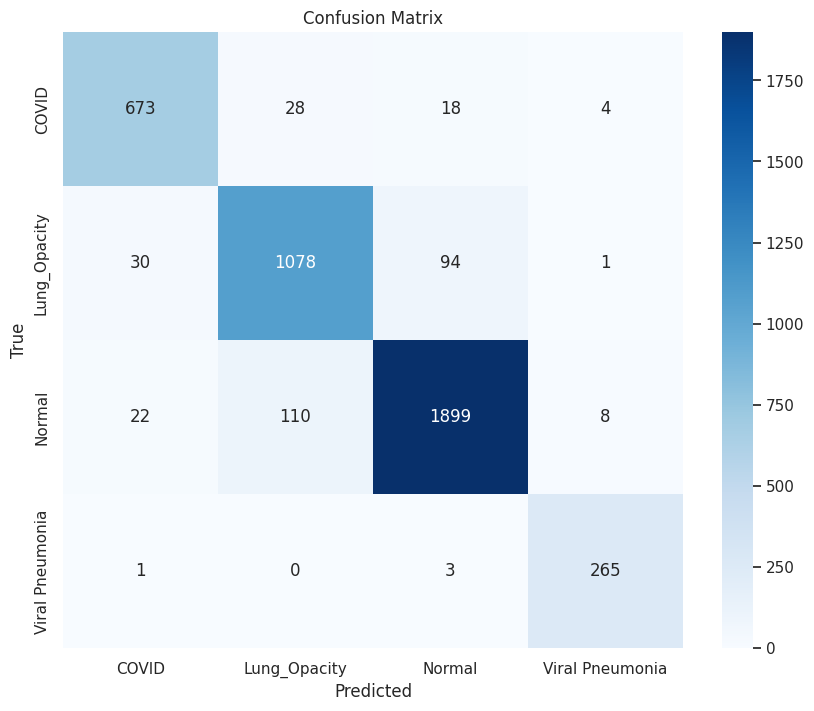

In [21]:
# Evaluate the model on the test set
evaluate_model(trained_model, test_loader, classes)

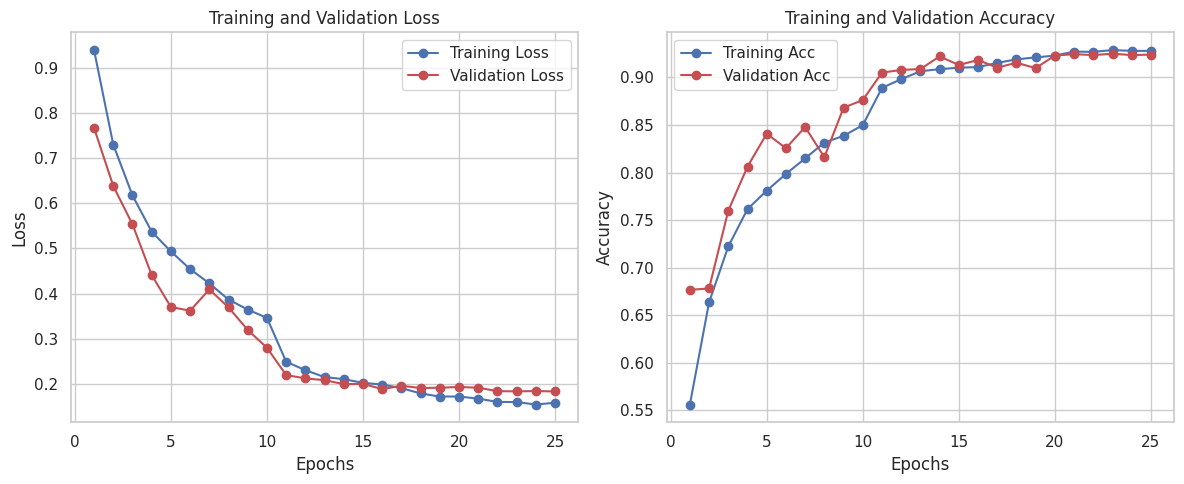

In [22]:
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot Accuracy
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Acc')
    plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# Plot training history
plot_history(history)

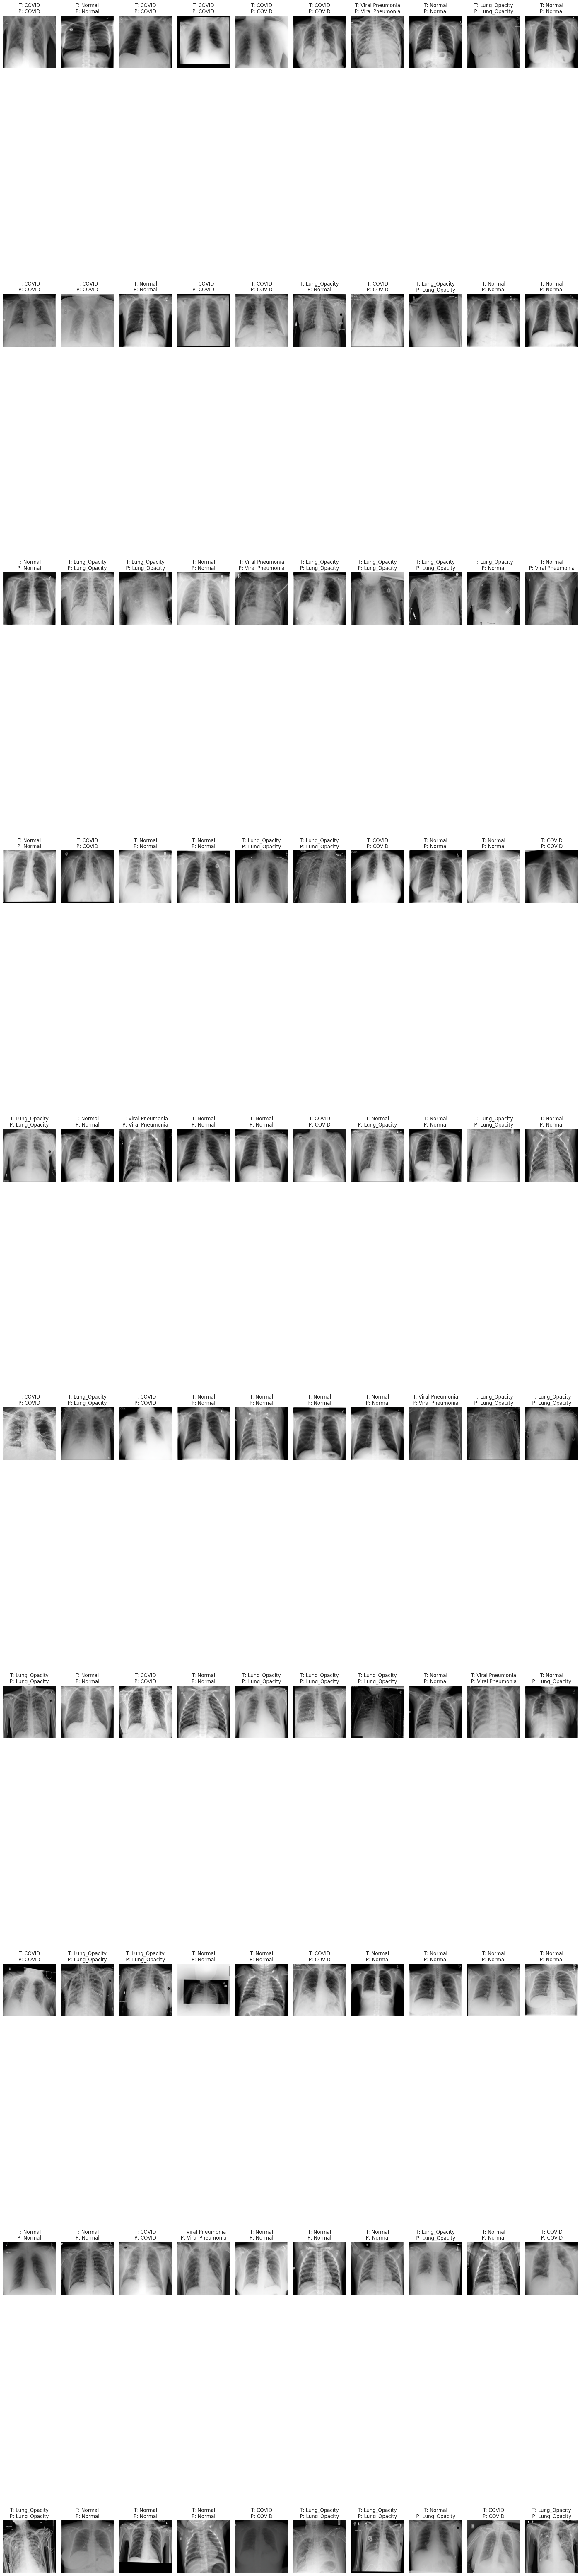

In [23]:
import random

def visualize_random_100_predictions(model, dataloader, classes, num_images=100):
    model.eval()
    collected_images, collected_labels, collected_preds = [], [], []
    
    with torch.no_grad():
        # Loop over the dataset and randomly sample images until we collect 100
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            
            # Move tensors to CPU for numpy conversion
            images = images.cpu().numpy()
            labels = labels.cpu().numpy()
            preds = preds.cpu().numpy()
            
            # Select a random subset of images from the batch if needed
            indices = list(range(images.shape[0]))
            random.shuffle(indices)
            for idx in indices:
                if len(collected_images) < num_images:
                    collected_images.append(images[idx])
                    collected_labels.append(labels[idx])
                    collected_preds.append(preds[idx])
                else:
                    break
            if len(collected_images) >= num_images:
                break  # Stop once we have 100 images

    # Plot the 100 random images with true and predicted labels
    plt.figure(figsize=(20, 100))  # Adjust figure size for better viewing
    for i in range(num_images):
        plt.subplot(num_images // 10, 10, i + 1)
        
        # Display the image
        img = collected_images[i].transpose((1, 2, 0))
        img = np.clip(img * np.array([0.229, 0.224, 0.225]) + 
                      np.array([0.485, 0.456, 0.406]), 0, 1)
        plt.imshow(img)
        plt.title(f"T: {classes[collected_labels[i]]}\nP: {classes[collected_preds[i]]}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize 100 random sample predictions
visualize_random_100_predictions(trained_model, test_loader, classes, num_images=100)
